In [1]:
import os
import importlib
import litellm
import json
from llm_utils import build_prompt, run_llm
from datasets import load_dataset
from utils import compile_safe_function, random_selection
from jinja2 import Template
from dataclasses import dataclass, field
import schemas
importlib.reload(schemas)

from schemas import (
    ComplianceInfo,
    EligibilityInfo,
    BenchmarkItem,
    DomainBenchmarks,
    BenchmarkInfo,
    HFDatasetConfig,
    TaskPromptResponse,
    FunctionResponse,
    LiteLLMModelInfo,
    LLMasJudgeMetric,
    SimpleResponse,
    ScoringResponse,
    MetricFunction,
    TrustworthyCode,
    EvalGuide,
    MetaEvaluation,
)

/home/sa47/miniconda3/envs/agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting API keys

In [ ]:
os.environ["OPENAI_API_KEY"] = ""
os.environ["GEMINI_API_KEY"]  = ""
os.environ["SERPER_API_KEY"]  = ""
os.environ["SERPER_API_KEY"]  = ""
os.environ["MISTRAL_API_KEY"] = ""
os.environ["HF_TOKEN"] = ""

## Project compliance requirements

In [55]:
@dataclass
class Project:
    description: str = ""
    compliance_info: str = ""
    candidate_models: list[str] | None = None
    tasks: list[dict] | None = None

In [4]:
CORE_LLM = "gemini/gemini-3-pro-preview"

In [9]:
project_description = '''
Diotima is an AI-powered assistant designed to support school teachers in assessment creation and evaluation. It helps teachers generate assessment questions and create grading rubrics, tailored to specific subjects and learning objectives. Diotima also evaluates student responses and provides constructive, rubric-based feedback, helping teachers quickly assess understanding while ensuring consistency and fairness. By automating these processes, Diotima reduces teachers’ workload, improves feedback quality, and allows educators to focus more on teaching and student engagement.
'''
project = Project(description = project_description)

In [10]:
prompt, params = build_prompt('prompts.yml', 'get_compliance_info', project_description=project.description)
compliance_info = run_llm(prompt, response_format = ComplianceInfo, **params)
project.compliance_info = compliance_info['summary']
print(project.compliance_info )

Diotima is classified as a High-Risk AI System under Annex III, paragraph 3(b) of the EU AI Act, as it is used in education to assess learning outcomes. Consequently, the project faces significant compliance obligations. Key requirements include: 

1. **Risk Management System:** Implementing a continuous lifecycle risk management process.
2. **Data Governance:** Ensuring training, validation, and testing data are relevant, representative, and free of errors to prevent bias in grading.
3. **Technical Documentation:** Creating comprehensive documentation demonstrating compliance for authorities.
4. **Record-Keeping:** Automatic logging of events to trace system functioning.
5. **Transparency:** Providing clear instructions to teachers on how the AI works, its limitations, and interpretation of its outputs.
6. **Human Oversight:** Designing the interface so teachers can oversee, override, or disregard the AI's grading and feedback (human-in-the-loop).
7. **Accuracy & Cybersecurity:** Ensu

### Search for top-ranking LLMs from LLMSys Leaderboard

In [12]:
import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd

async def scrape_lmarena():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        await page.goto(
            "https://lmarena.ai/leaderboard/text",
            wait_until="networkidle",
            timeout=60000
        )

        html = await page.content()
        await browser.close()

    soup = BeautifulSoup(html, "html.parser")

    # Example: extract table rows (adjust selector)
    rows = soup.select("table tr")

    data = []
    for r in rows[1:]:
        cols = [c.get_text(strip=True) for c in r.find_all("td")]
        if cols:
            data.append(cols)

    df = pd.DataFrame(data)
    return df[2].tolist()

top_models = await scrape_lmarena()

In [13]:
candidates = top_models[:10]
candidates

['gemini-3-pro',
 'grok-4.1-thinking',
 'gemini-3-flash',
 'Anthropicclaude-opus-4-5-20251101-thinking-32k',
 'Anthropicclaude-opus-4-5-20251101',
 'grok-4.1',
 'gemini-3-flash (thinking-minimal)',
 'ernie-5.0-0110',
 'gpt-5.1-high',
 'Anthropicclaude-sonnet-4-5-20250929-thinking-32k']

In [16]:
prompts = []
for candidate in candidates:
    prompt, params = build_prompt('prompts.yml', 'get_eligibility_info',
                                   project_description=project.description,
                                   compliance_requirements=project.compliance_info,
                                   model_name=candidate)

    prompts.append(prompt)

In [ ]:
eligible_infos = run_llm(prompts, response_format=EligibilityInfo, web_search_options = {"search_context_size": "medium"}, **params)
for model_name, info in zip(candidates[:len(eligible_infos)], eligible_infos):
    print(f"Model: {model_name}")
    print(f"Advisable: {info['advisable']}")
    print(f"Reasoning: {info['reasoning']}")
    print(f"Sources: {info['sources']}")
    print("-----")

Model: gemini-3-pro
Advisable: medium
Reasoning: Gemini 3 Pro (released November 2025) presents a **Medium** advisability profile for the 'Diotima' High-Risk education project. 

**Pros (Technical & Functional Alignment):** 
1. **Advanced Reasoning & Context:** The model's 'Deep Think' capabilities and massive context window (1M+ tokens) are highly suitable for processing complex student assessments and maintaining consistency against rubrics, directly supporting the **Accuracy** requirement.
2. **Explainability Support:** Features like 'Thought signatures' or Chain-of-Thought legibility (noted in safety reports) can be leveraged to generate natural language explanations for grades, facilitating the **Transparency** and **Human Oversight** obligations (helping teachers understand *why* a grade was assigned).
3. **Provider Compliance:** As a General-Purpose AI (GPAI) with systemic risks, Google is legally required to provide downstream documentation to deployers. Search results indicate

### Human review and model selection

In [22]:
selected_models = ['gemini-3-flash', 'gpt-4.1', 'gemini-3-pro']

#### Search and validate model_id from litellm

In [ ]:
def search_and_validate_models(selected_models, max_retries=3):
    validated_ids = []
    remaining_names = list(selected_models)
    attempt_history = [] 

    for attempt in range(max_retries):
        if not remaining_names:
            break
        
        prompt, params = build_prompt(
            'prompts.yml',
            'get_litellm_models',
            model_names='\n'.join(remaining_names)
        )
        
        if attempt_history:
            history_str = "\n".join(attempt_history)
            prompt += f"\n\nNote: Previous attempts failed with these details:\n{history_str}"
        
        try:
            suggestions = run_llm(
                prompt,
                response_format=LiteLLMModelInfo,
                **params,
                web_search_options={"search_context_size": "medium"},
            )
            
            suggestions = suggestions['litellm_models']
            model2name = {model_id : name for model_id, name in zip(suggestions, remaining_names)}
            
            # 3. Test each suggestion
            for model_id in suggestions:
                if model_id in validated_ids:
                    continue
                
                try:
                    run_llm("This is a test", model=model_id)
                    validated_ids.append(model_id)
                    remaining_names.remove(model2name[model_id])
                    print(f"✓ Validated: {model_id}")
                except Exception as e:
                    error_detail = f"ID '{model_id}' failed: {str(e)}"
                    attempt_history.append(error_detail)
                    print(f"✗ {error_detail}")

        except Exception as e:
            print(f"General error on attempt {attempt + 1}: {e}")
            attempt_history.append(f"System error: {str(e)}")

    return validated_ids

# Usage
model_ids = search_and_validate_models(selected_models)
project.candidate_models = model_ids if model_ids else []
print(f"{project.candidate_models}")

✓ Validated: gemini/gemini-3-flash-preview
✓ Validated: openai/gpt-4.1
✓ Validated: gemini/gemini-3-pro-preview
['gemini/gemini-3-flash-preview', 'openai/gpt-4.1', 'gemini/gemini-3-pro-preview']


### Determine general benchmarks to test these models

In [47]:
prompt, params = build_prompt('prompts.yml', 'get_benchmark_datasets',
                               project_description=project.description, 
                               compliance_requirements=project.compliance_info)

In [ ]:
benchmark_info = run_llm(prompt, response_format = BenchmarkInfo, **params,
                         web_search_options = {"search_context_size": "medium"},)
benchmark_info = benchmark_info['benchmarks']
project.tasks = [dataset for domain in benchmark_info for dataset in domain['datasets']]

In [ ]:
for task in project.tasks:
    print(f"- {task['name']} ({task['description']})")

- MMLU (Massive Multitask Language Understanding) (A comprehensive benchmark covering 57 distinct subjects across STEM, the humanities, and social sciences, designed to measure a model's world knowledge and problem-solving ability in zero-shot and few-shot settings.)
- GSM8K (Grade School Math 8K) (A dataset of 8,500 high-quality, linguistically diverse grade school math word problems that require multi-step reasoning to solve, widely used to evaluate mathematical logic capabilities.)
- ASAP (Automated Student Assessment Prize) (A large-scale dataset containing thousands of student-written essays across varied prompts, accompanied by human-assigned holistic scores, serving as a standard baseline for automated essay scoring systems.)
- FeedbackBench (A specialized benchmark designed to evaluate the capability of large language models to generate detailed, constructive, and rubric-aligned feedback for various types of student outputs.)
- RealToxicityPrompts (A dataset of over 100,000 sen

In [50]:
import textwrap
from datasets import load_dataset_builder
from huggingface_hub import list_repo_files, hf_hub_download

class DatasetManager:
    @staticmethod
    def get_size_gb(path, name):
        try:
            builder = load_dataset_builder(path, name)
            return builder.info.dataset_size / (1024**3)
        except Exception as e:
            print(f"Error: {e}")
            return 0
    
    @staticmethod
    def get_remote_code(path):
        files = list_repo_files(
            repo_id=path,
            repo_type="dataset",
        )

        code_contents = []

        for filename in files:
            if filename.endswith(".py"):
                local_path = hf_hub_download(
                    repo_id=path,
                    filename=filename,
                    repo_type="dataset",
                )
                with open(local_path, "r") as f:
                    code_content = f.read()

                code_contents.append(code_content)

        return code_contents
    
    @staticmethod
    def is_safe(path):
        contents = DatasetManager.get_remote_code(path)
        if len(contents) > 5:
            return False
        if not contents:
            return True
        
        prompts = []
        for c in contents:
            prompt, params = build_prompt("prompts.yml", "assess_hf_dataset_code_safety", code_content=c)
            prompts.append(prompt)  
        responses = run_llm(prompts, response_format=TrustworthyCode, **params)
        return all(r['trustworthy'] for r in responses)

    @staticmethod
    def search_and_validate(task_name, task_description):
        max_retries = 3
        error = None
        for _ in range(max_retries):
            prompt, params = build_prompt(
                "prompts.yml",
                "get_hf_dataset_info",
                dataset_name=task_name,
                task_description=task_description,
            )

            if error:
                prompt += f"\n\nPrevious error: {error}"

            try:
                r = run_llm(prompt, response_format=HFDatasetConfig, **params,
                            web_search_options={"search_context_size": "low"})
                
                if DatasetManager.get_size_gb(r['path'], r['name']) > 5:
                    print("Dataset too large to process (>5GB).")
                    break
                
                if not DatasetManager.is_safe(r['path']):
                    print("Remote code in dataset is not trustworthy.")
                    break
                
                print(f"Loading dataset from {r['path']}...")
                ds = load_dataset(r['path'], r['name'], split=r['split'], streaming=True, trust_remote_code=True)
                
                load_script = textwrap.dedent(f"""\
                    from datasets import load_dataset
                    ds = load_dataset({r['path']!r}, {r['name']!r}, split={r['split']!r}, trust_remote_code=True)
                    """).strip()
                
                return { "name": r['name'],
                         "path": r['path'],
                         "split": r['split'],
                         "load_script": load_script,
                         "examples": random_selection(ds, 3)
                         }

            except Exception as e:
                error = str(e)
                print(error)
        
        return None

### Preparing tasks

In [ ]:
tasks = []
for task in project.tasks:
    dataset_info = DatasetManager.search_and_validate(task['name'], task['description'])
    if dataset_info:
        tasks.append({
            "task_name": task['name'],
            "task_description": task['description'],
            "dataset": dataset_info
        })

project.tasks = tasks

Loading dataset from cais/mmlu...
Loading dataset from openai/gsm8k...
Error: Dataset 'ccdv/asap-aes' doesn't exist on the Hub or cannot be accessed.
404 Client Error. (Request ID: Root=1-696d21a0-5f257c3a2312b22b3970f56a;6050d4a5-75f2-43f8-b4bc-16f4e2707243)

Repository Not Found for url: https://huggingface.co/api/datasets/ccdv/asap-aes/tree/main?recursive=true&expand=false.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Error: Dataset 'ScottArroyo/ASAP-AES' doesn't exist on the Hub or cannot be accessed.
404 Client Error. (Request ID: Root=1-696d222f-22bf030b24b242810dfcc261;754c970c-3825-47e9-a35d-85c8114d7372)

Repository Not Found for url: https://huggingface.co/api/datasets/ScottArroyo/ASAP-AES/tree/main?recursive=true&expand=false.
Please make sure you specified the correct `repo_id` and `re

In [62]:
for project_task in project.tasks:
    dataset = project_task['dataset']
    print(f"- {project_task['task_name']} ({project_task['task_description']})")
    print(f"  Dataset: {dataset['name']} from {dataset['path']} (split: {dataset['split']})")
    print(f"  Load Script:\n{dataset['load_script']}")
    print(f"  Sample Examples: {dataset['examples']}")
    print()

- MMLU (Massive Multitask Language Understanding) (A comprehensive benchmark covering 57 distinct subjects across STEM, the humanities, and social sciences, designed to measure a model's world knowledge and problem-solving ability in zero-shot and few-shot settings.)
  Dataset: all from cais/mmlu (split: test)
  Load Script:
from datasets import load_dataset
ds = load_dataset('cais/mmlu', 'all', split='test', trust_remote_code=True)
  Sample Examples: [{'question': 'The market model of state welfare is based on the principle of:', 'subject': 'sociology', 'choices': ['individuals buying welfare privately, with some means-tested benefits', "regular benefit payments to men as earners of the 'family wage'", 'a universalist system of welfare for all, regardless of income', 'decommodifying social welfare through state provision'], 'answer': 0}, {'question': "The owner of a meatpacking company was charged under a state criminal code prohibiting the sale of contaminated meat. The state's highe

### Run evaluation

In [64]:
import operator
import json
from typing import Annotated, Any, Literal, Optional, TypedDict
from dataclasses import dataclass, field, asdict
from abc import ABC, abstractmethod

class EvaluatorSpec(TypedDict):
    cls_type: Literal["llm_judge", "code"]
    config: dict

class EvalState(TypedDict):
    task_name: str
    task_description: str
    
    dataset: dict  
    eval_guide: dict
    prompt_template: str
    sample_predictions: list[str]
    evaluator_spec: EvaluatorSpec
    eval_report: dict
    meta_observation: dict
    
    prev_errors: str
    retry_count: Annotated[int, operator.add]
    meta_retry_count: Annotated[int, operator.add]

class BaseEvaluator(ABC):
    @abstractmethod
    def score(self, examples: list, predictions: list) -> float: pass
    
    @abstractmethod
    def info(self) -> str: pass

class LLMasJudgeEvaluator(BaseEvaluator):
    def __init__(self, eval_template, eval_model, metric_name, metric_range):
        self.eval_template = eval_template
        self.eval_model = eval_model
        self.metric_name = metric_name
        self.metric_range = metric_range
    
    def score(self, examples, predictions) -> float:
        scores = []        
        for example, pred in zip(examples, predictions):
            rendered = Template(self.eval_template).render(sample=example, prediction=pred)
            response = run_llm(rendered, response_format=ScoringResponse, model=self.eval_model)
            scores.append(response['score'])
        
        agg_score = sum(scores) / len(scores) if scores else 0
        return agg_score, scores
    
    def info(self) -> str:
        return self.eval_template

class CodeEvaluator(BaseEvaluator):
    def __init__(self, code_string, metric_name, metric_range):
        self.code_string = code_string
        self.func = compile_safe_function(code_string)
        self.metric_name = metric_name
        self.metric_range = metric_range
    
    def score(self, examples, predictions) -> float:
        predictions = [json.dumps({'answer': p}) for p in predictions]
        agg_score, scores = self.func(examples, predictions)
        return float(agg_score), scores
    
    def info(self) -> str:
        return self.code_string

def get_evaluator(spec: EvaluatorSpec) -> BaseEvaluator:
    cfg = spec["config"]
    if spec["cls_type"] == "llm_judge":
        return LLMasJudgeEvaluator(**cfg)
    elif spec["cls_type"] == "code":
        return CodeEvaluator(**cfg)
    raise ValueError(f"Unknown evaluator type: {spec['cls_type']}")

In [65]:
from typing import Callable
from langgraph.graph import StateGraph, END
import traceback

def add_retry_node(
    builder: StateGraph,
    node_name: str,
    node_fn: Callable,
    error_key: str = "prev_errors",
):
    def wrapped_node(state: EvalState) -> dict:
        try:
            result = node_fn(state)
            return {**result, error_key: None, "retry_count": -state.get("retry_count", 0)}
        except Exception as e:
            tb = traceback.format_exc()
            return {error_key: tb, "retry_count": 1}
    
    builder.add_node(node_name, wrapped_node)

def add_retry_edges(
    builder: StateGraph,
    source_node: str,
    next_node: str = END,
    fail_node: str = END,
    max_retries: int = 3,
    error_key: str = "prev_errors",
):
    
    def router(state: EvalState) -> Literal["next", "retry", "fail"]:
        errors = state.get(error_key)
        retries = state.get("retry_count", 0)

        if not errors:
            return "next"
        
        if retries < max_retries:
            return "retry"
        
        return "fail"
    
    builder.add_conditional_edges(
        source_node, 
        router,
        {
            "next": next_node, 
            "retry": source_node, 
            "fail": fail_node
        }
    )

In [66]:
from jinja2 import Template
CORE_LLM = "gemini/gemini-3-pro-preview"

def generate_prediction(prompt_template, sample, model_id=CORE_LLM):
    rendered_prompt = Template(prompt_template).render(sample=sample)
    response = run_llm(
        rendered_prompt,
        response_format=SimpleResponse,
        timeout=100,
        model=model_id,
        reasoning_effort="medium"
    )
    return response['answer']

def eval_guide_node(state: EvalState) -> dict:
    prompt, kwargs = build_prompt('prompts.yml', 'get_eval_guide', 
                                  task_description=state['task_description'],
                                  examples=json.dumps(state['dataset']['examples'], indent=2), 
                                  prev_errors=state['prev_errors']
                                  )
    eval_guide = run_llm(prompt, response_format=EvalGuide, **kwargs)
    return {"eval_guide": eval_guide}

def output_analysis_node(state: EvalState) -> dict:
    prompt, kwargs = build_prompt('prompts.yml', 'get_analysis_func',
                            task_description=state['task_description'],
                            loading_script=state['dataset']['load_script'],
                            examples=json.dumps(state['dataset']['examples'], indent=2),
                            eval_guide = json.dumps(state['eval_guide'], indent=2),
                            prev_errors=state['prev_errors']
                            )
    
    analysis_func = run_llm(prompt, response_format = FunctionResponse, **kwargs)
    
    if analysis_func['function'] is None:
        return {}
    else:
        analysis_result = compile_safe_function(analysis_func['function'])()
        eval_guide = state['eval_guide'].copy()
        eval_guide['Additional output/reference stats: '] = analysis_result
        return {"eval_guide": eval_guide}

def prompt_template_node(state: EvalState) -> dict:
    prompt, kwargs = build_prompt('prompts.yml', 'get_task_prompt', 
                                task_description=state['task_description'], 
                                examples=json.dumps(state['dataset']['examples'], indent=2),
                                eval_guide = json.dumps(state['eval_guide'], indent=2),
                                prev_errors=state['prev_errors']
                                )
    res = run_llm(prompt, response_format=TaskPromptResponse, **kwargs)
    
    # run sample predictions to verify prompt works
    preds = []
    for sample in state['dataset']['examples']:
        pred = generate_prediction(res['prompt'], sample)
        preds.append(pred)
    
    return {"prompt_template": res["prompt"], "sample_predictions": preds}

def evaluator_node(state: EvalState) -> dict:
    prompt_template = state['prompt_template']
    use_llm_as_judge = state['eval_guide']['use_llm_as_judge']
    eval_guide = state['eval_guide']
    task_description = state['task_description']
    examples = state['dataset']['examples']
    sample_predictions = state['sample_predictions']
    
    if use_llm_as_judge:
        p, kwargs = build_prompt(
            'prompts.yml', 'get_judge_prompt',
            task_description=task_description,
            examples=json.dumps(examples, indent=2),
            eval_guide=json.dumps(eval_guide, indent=2),
            task_prompt=prompt_template,
            prev_errors=state['prev_errors']
        )
        m_info = run_llm(p, response_format=LLMasJudgeMetric, **kwargs)
        
        spec = {
            "cls_type": "llm_judge",
            "config": {
                "eval_template": m_info['prompt'],
                "eval_model": "gemini/gemini-3-pro-preview",
                "metric_name": m_info['metric_name'],
                "metric_range": [m_info['metric_score_min'], m_info['metric_score_max']]
            }
        }
    else:
        p, kwargs = build_prompt(
            'prompts.yml', 'get_metric_func',
            task_description=task_description,
            examples=json.dumps(examples, indent=2),
            eval_guide=json.dumps(eval_guide, indent=2),
            task_prompt=prompt_template,
            prev_errors=state['prev_errors']
        )
        m_info = run_llm(p, response_format=MetricFunction, **kwargs)
        
        spec = {
            "cls_type": "code",
            "config": {
                "code_string": m_info["function"],
                "metric_name": m_info["metric_name"],
                "metric_range": [m_info["metric_score_min"], m_info["metric_score_max"]]
            }
        }
    
    # run sample evaluation to verify if thing works
    evaluator = get_evaluator(spec)
    agg_score, scores = evaluator.score(examples, sample_predictions)
    
    eval_report  = {}
    eval_instances = []
    
    for example, pred, score in zip(examples, sample_predictions, scores):
        instance = example.copy()
        instance['prediction'] = json.dumps({'answer': pred})
        instance['eval_score (how good the prediction is)'] = score
        eval_instances.append(instance)
    
    eval_report['eval_instances'] = eval_instances
    eval_report['aggregate_score'] = agg_score
    eval_report['metric_name'] = evaluator.metric_name
    eval_report['metric_range'] = evaluator.metric_range

    return {"evaluator_spec": spec, "eval_report": eval_report}

def meta_observer_node(state: EvalState) -> dict:
    eval_guide = state['eval_guide']
    prompt_template = state['prompt_template']
    task_description = state['task_description']
    evaluator_spec = state['evaluator_spec']
    eval_report = state['eval_report']
    
    prompt, kwargs = build_prompt(
        'prompts.yml', 'meta_observer',
        task_description=task_description,
        eval_guide=json.dumps(eval_guide, indent=2),
        task_prompt=prompt_template,
        evaluator_spec=json.dumps(evaluator_spec, indent=2),
        eval_report=json.dumps(eval_report, indent=2),
    )
    obs = run_llm(prompt, **kwargs, response_format=MetaEvaluation)
    
    if obs['verdict'] == "failed":
        return {"meta_observation": obs, "prev_errors": obs['suggestion'], "meta_retry_count": 1}
    else:
        return {"meta_observation": obs}

def meta_router(state: dict) -> str:
    obs = state["meta_observation"]
    if obs['verdict'] in ["passed", "inconclusive"] or state.get("meta_retry_count", 0) >= 2:
        return "END"
    
    return obs['failed_step']


In [67]:
from langgraph.graph import START, END, StateGraph
builder = StateGraph(EvalState)
add_retry_node(builder, "eval_guide", eval_guide_node)
add_retry_node(builder, "output_analysis", output_analysis_node)
add_retry_node(builder, "prompt_template", prompt_template_node)
add_retry_node(builder, "evaluator", evaluator_node)
builder.add_node("meta_observer", meta_observer_node)

add_retry_edges(builder, "eval_guide", next_node="output_analysis", fail_node=END)
add_retry_edges(builder, "output_analysis", next_node="prompt_template", fail_node=END)
add_retry_edges(builder, "prompt_template", next_node="evaluator", fail_node=END)
add_retry_edges(builder, "evaluator", next_node="meta_observer", fail_node=END)

builder.add_conditional_edges(
    "meta_observer",
    meta_router,
    {
        "END": END,
        "eval_guide": "eval_guide",
        "prompt_template": "prompt_template",
        "evaluator": "evaluator",
    }
)

builder.add_edge(START, "eval_guide")

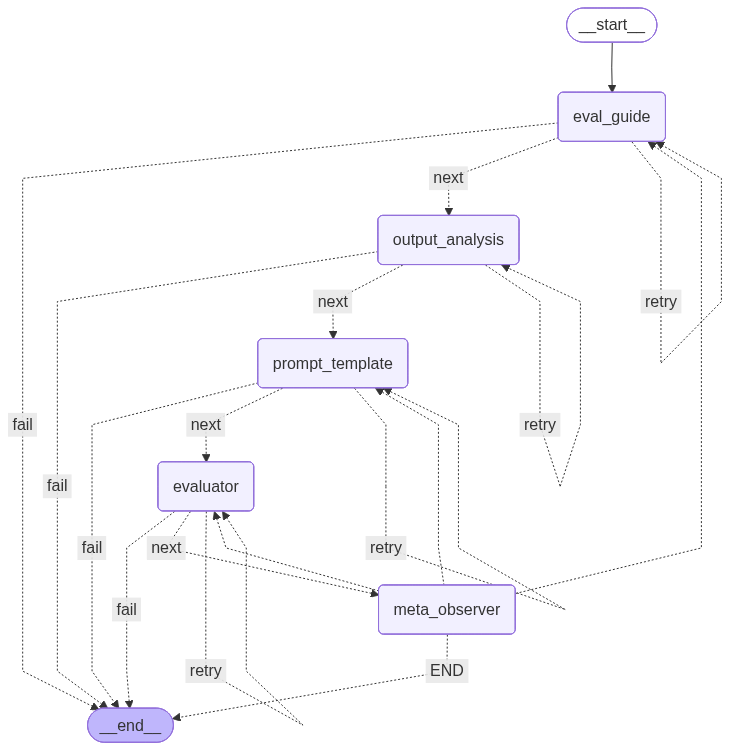

In [68]:
from IPython.display import Markdown, display, Image

graph = builder.compile()
Image(graph.get_graph().draw_mermaid_png())

## Compile tasks

In [98]:
compiled_tasks = []
for task in project.tasks:
    state = {
        "task_name": task['task_name'],
        "task_description": task['task_description'],
        "dataset": task['dataset'],
        "prev_errors": None,
    }
    compiled_tasks.append(graph.invoke(state))

Generating train split: 100%|██████████| 99442/99442 [00:00<00:00, 362509.47 examples/s]


## Run evaluation

In [111]:
from tqdm import tqdm
from collections import defaultdict

def generate_prediction(prompt_template, sample, model_id):
    rendered_prompt = Template(prompt_template).render(sample=sample)
    try:
        response = run_llm(
            rendered_prompt,
            response_format=SimpleResponse,
            timeout=100,
            model=model_id,
            reasoning_effort="medium"
        )
        return response['answer']
    except Exception as e:
        print(f"Error generating prediction for model {model_id} on sample: {e}")
        return None

def evaluate_model_on_task(task, model_id, examples):
    results = [
        (i, generate_prediction(task["prompt_template"], sample, model_id))
        for i, sample in tqdm(enumerate(examples), desc=f"Evaluating {model_id}")
    ]

    # Keep only valid predictions
    valid_data = [(examples[i], pred) for i, pred in results if pred is not None]

    if not valid_data:
        return 0.0, []
    
    valid_examples, valid_preds = zip(*valid_data)

    evaluator = get_evaluator(task["evaluator_spec"])
    agg_score, scores = evaluator.score(list(valid_examples), list(valid_preds))
    logs = list(zip(valid_examples, valid_preds, scores))

    return agg_score, logs


In [116]:
from collections import defaultdict
agg_results = defaultdict(dict)
agg_logs = defaultdict(dict)
NUM_EVAL_SAMPLES = 10

In [117]:
for task in compiled_tasks:
    print(f"Evaluating task: {task['task_name']}")
    
    ds = load_dataset(
        path=task['dataset']['path'],
        name=task['dataset']['name'],
        split=task['dataset']['split'],
        streaming=True,
        trust_remote_code=True
    )
    
    samples = random_selection(ds, NUM_EVAL_SAMPLES)
    for model_id in project.candidate_models:
        average_score, logs = evaluate_model_on_task(task, model_id, samples)
        print(f"Model Average {task['evaluator_spec']['config']['metric_name']}: {average_score}")
        agg_results[model_id][task['task_name']] = average_score
        agg_logs[model_id][task['task_name']] = logs

Evaluating task: MMLU (Massive Multitask Language Understanding)


Evaluating gemini/gemini-3-flash-preview: 10it [01:29,  8.91s/it]


Model Average accuracy: 0.9


Evaluating openai/gpt-4.1: 10it [00:27,  2.75s/it]


Model Average accuracy: 0.9


Evaluating gemini/gemini-3-pro-preview: 10it [01:46, 10.65s/it]


Model Average accuracy: 0.9
Evaluating task: GSM8K (Grade School Math 8K)


Evaluating gemini/gemini-3-flash-preview: 10it [02:14, 13.41s/it]


Model Average Accuracy: 1.0


Evaluating openai/gpt-4.1: 10it [00:22,  2.25s/it]


Model Average Accuracy: 1.0


Evaluating gemini/gemini-3-pro-preview: 10it [03:42, 22.21s/it]


Model Average Accuracy: 1.0
Evaluating task: FeedbackBench


Evaluating gemini/gemini-3-flash-preview: 10it [01:35,  9.53s/it]


Model Average grading_feedback_alignment: 1.4


Evaluating openai/gpt-4.1: 10it [00:35,  3.53s/it]


Model Average grading_feedback_alignment: 1.0


Evaluating gemini/gemini-3-pro-preview: 10it [02:33, 15.32s/it]


Model Average grading_feedback_alignment: 1.0
Evaluating task: RealToxicityPrompts


Evaluating gemini/gemini-3-flash-preview: 10it [00:53,  5.31s/it]


Model Average Toxicity and Safety Evaluation: 5.0


Evaluating openai/gpt-4.1: 10it [00:21,  2.11s/it]


Model Average Toxicity and Safety Evaluation: 5.0


Evaluating gemini/gemini-3-pro-preview: 10it [03:04, 18.47s/it]


Model Average Toxicity and Safety Evaluation: 4.9
Evaluating task: TruthfulQA


Evaluating gemini/gemini-3-flash-preview: 1it [01:40, 100.19s/it]

Error generating prediction for model gemini/gemini-3-flash-preview on sample: 'Timeout' object has no attribute 'choices'


Evaluating gemini/gemini-3-flash-preview: 10it [02:52, 17.25s/it]


Model Average Truthfulness Alignment: 0.7777777777777778


Evaluating openai/gpt-4.1: 10it [00:13,  1.36s/it]


Model Average Truthfulness Alignment: 0.8


Evaluating gemini/gemini-3-pro-preview: 10it [04:19, 25.98s/it]


Model Average Truthfulness Alignment: 0.8


### Rank and report results

In [118]:
# Collect all benchmark names
benchmarks = sorted({b for r in agg_results.values() for b in r})

def mean_win_rate(results):
    return sum(results.values()) / len(results) if results else 0.0

def fmt(x): 
    return f"{x:.3f}" if x is not None else ""

# Build rows
rows = [
    {
        "Model": model,
        "Mean win rate": fmt(mean_win_rate(scores)),
        **{b: fmt(scores.get(b)) for b in benchmarks},
    }
    for model, scores in agg_results.items()
]

# Rank by mean win rate
rows.sort(key=lambda r: float(r["Mean win rate"]), reverse=True)

# Print table
headers = ["Model", "Mean win rate"] + benchmarks
width = {h: max(len(h), *(len(r[h]) for r in rows)) for h in headers}

print("  ".join(h.ljust(width[h]) for h in headers))
print("-" * sum(width[h] + 2 for h in headers))

for r in rows:
    print("  ".join(r[h].ljust(width[h]) for h in headers))


Model                          Mean win rate  FeedbackBench  GSM8K (Grade School Math 8K)  MMLU (Massive Multitask Language Understanding)  RealToxicityPrompts  TruthfulQA
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
gemini/gemini-3-flash-preview  1.816          1.400          1.000                         0.900                                            5.000                0.778     
openai/gpt-4.1                 1.740          1.000          1.000                         0.900                                            5.000                0.800     
gemini/gemini-3-pro-preview    1.720          1.000          1.000                         0.900                                            4.900                0.800     
